In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict # Added StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, make_scorer, classification_report # Added make_scorer, classification_report
from sklearn.svm import SVC # New import
from xgboost import XGBClassifier # New import
from sklearn.preprocessing import StandardScaler, LabelEncoder # New import
from sklearn.linear_model import LogisticRegression # New import for meta-learner
from ta.momentum import RSIIndicator
from ta.trend import MACD
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")


# --- Performance Metrics Functions ---

def annualized_returns(returns):
    """
    Calculate the annualized returns from daily returns.
    Assumes 252 trading days in a year.
    """
    return (1 + returns).prod()**(252/len(returns)) - 1

def sharpe_ratio(returns, risk_free_rate=0.0):
    """
    Calculate the annualized Sharpe Ratio.
    Assumes 252 trading days in a year.
    """
    excess_returns = returns - risk_free_rate / 252
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

def max_drawdown(cumulative_returns):
    """
    Calculate the maximum drawdown from a series of cumulative returns.
    """
    if cumulative_returns.empty:
        return 0.0
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()
# Define target labels for multi-class classification (consistent with 04_signal_prediction)
LABELS = [-1, 0, 1]

# Create a custom multi-class ROC AUC scorer for GridSearchCV (if used later)
multi_class_roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', labels=LABELS)

In [17]:
def fetch_data(symbol, api_key=API_KEY):
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, _ = ts.get_daily(symbol=symbol, outputsize='full')
    data = data.sort_index()
    data = data.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume'
    })
    return data


In [18]:
# Apply indicators per ticker
def add_features(df):
    df['return'] = df['close'].pct_change()
    df['rsi'] = RSIIndicator(df['close'], window=14).rsi()
    macd = MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()

    # Multi-class target definition (consistent with 04_signal_prediction)
    BUY_THRESHOLD = 0.001
    SELL_THRESHOLD = -0.001
    df['target'] = 0
    df.loc[df['return'].shift(-1) > BUY_THRESHOLD, 'target'] = 1
    df.loc[df['return'].shift(-1) < SELL_THRESHOLD, 'target'] = -1

    df.dropna(inplace=True)
    return df

In [19]:
# Train RandomForest, XGBoost, SVM models, and then a Stacking ensemble
# This function will return the strategy series for each model type
def train_evaluate_all_models(df): # Renamed function for clarity
    features = ['rsi', 'macd', 'macd_signal']
    X = df[features]
    y = df['target']

    # Encode target labels for XGBoost (if targets are -1, 0, 1)
    le = LabelEncoder()
    # Fit transform on the entire y to ensure consistent mapping for train/test
    y_encoded_full = le.fit_transform(y)

    # Split data into training and testing sets (shuffle=False for time series)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    y_train_encoded = le.transform(y_train)
    y_test_encoded = le.transform(y_test) # Though not used directly for y_test_encoded, good practice

    # Scale data for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    # --- Base Models ---
    # RandomForest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)
    strategy_rf_series = pd.Series(np.where(y_pred_rf == 1, df.loc[X_test.index, 'return'],
                                            np.where(y_pred_rf == -1, -df.loc[X_test.index, 'return'], 0)),
                                  index=X_test.index)

    # XGBoost
    # For multi-class classification, use objective='multi:softproba' to get probabilities directly
    xgb_model = XGBClassifier(objective='multi:softproba', num_class=len(LABELS),
                              use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train_encoded)
    y_pred_xgb_encoded = xgb_model.predict(X_test)
    y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)
    y_proba_xgb = xgb_model.predict_proba(X_test)
    strategy_xgb_series = pd.Series(np.where(y_pred_xgb == 1, df.loc[X_test.index, 'return'],
                                             np.where(y_pred_xgb == -1, -df.loc[X_test.index, 'return'], 0)),
                                   index=X_test.index)

    # SVM
    svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
    svm_model.fit(X_train_scaled_df, y_train)
    y_pred_svm = svm_model.predict(X_test_scaled_df)
    y_proba_svm = svm_model.predict_proba(X_test_scaled_df)
    strategy_svm_series = pd.Series(np.where(y_pred_svm == 1, df.loc[X_test.index, 'return'],
                                             np.where(y_pred_svm == -1, -df.loc[X_test.index, 'return'], 0)),
                                   index=X_test.index)

    # --- Stacking Ensemble ---
    # Generate Out-Of-Fold (OOF) predictions for meta-learner training
    kf = StratifiedKFold(n_splits=5, shuffle=False) # Use shuffle=False for time series data

    rf_oof_proba = cross_val_predict(rf_model, X_train, y_train, cv=kf, method='predict_proba', n_jobs=-1)
    xgb_oof_proba = cross_val_predict(xgb_model, X_train, y_train_encoded, cv=kf, method='predict_proba', n_jobs=-1)
    svm_oof_proba = cross_val_predict(svm_model, X_train_scaled_df, y_train, cv=kf, method='predict_proba', n_jobs=-1)

    X_meta_train = np.hstack((rf_oof_proba, xgb_oof_proba, svm_oof_proba))
    y_meta_train = y_train

    meta_learner = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=42, class_weight='balanced', max_iter=1000)
    meta_learner.fit(X_meta_train, y_meta_train)

    X_meta_test = np.hstack((y_proba_rf, y_proba_xgb, y_proba_svm))
    y_pred_stack = meta_learner.predict(X_meta_test)

    strategy_stack_series = pd.Series(np.where(y_pred_stack == 1, df.loc[X_test.index, 'return'],
                                               np.where(y_pred_stack == -1, -df.loc[X_test.index, 'return'], 0)),
                                      index=X_test.index)

    # Return all individual strategy series for later portfolio optimization
    return strategy_rf_series, strategy_xgb_series, strategy_svm_series, strategy_stack_series

In [20]:
# Suppose we already have strategy_returns = { 'AAPL': series1, 'MSFT': series2, ... }

from scipy.optimize import minimize

def optimize_portfolio(returns_dict):
    returns_df = pd.DataFrame(returns_dict)
    weights = np.ones(len(returns_df.columns)) / len(returns_df.columns)

    def neg_sharpe(w):
        port_return = (returns_df * w).sum(axis=1)
        return -np.sqrt(252) * port_return.mean() / port_return.std()

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(weights)

    result = minimize(neg_sharpe, weights, bounds=bounds, constraints=constraints)
    return result.x, -result.fun


In [21]:
example_tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'JPM', 'BA']

print("🔢 Example Tickers:")
for i, ticker in enumerate(example_tickers):
    print(f"{i+1}. {ticker}")

chosen_indices = input("Please choose 5 ticker indices (comma-separated, e.g. 1,3,5,7,9): ")
chosen_tickers = [example_tickers[int(i)-1] for i in chosen_indices.split(',')]

print(f"\n✅ You selected: {chosen_tickers}")


🔢 Example Tickers:
1. AAPL
2. MSFT
3. GOOG
4. AMZN
5. META
6. TSLA
7. NFLX
8. NVDA
9. JPM
10. BA

✅ You selected: ['AAPL', 'GOOG', 'AMZN', 'META', 'TSLA']


In [22]:
import json



# ✅ Save to file for reuse
ticker_save_path = "/workspaces/backtesting/investment-portfolio-project/data/selected_tickers.json"
with open(ticker_save_path, 'w') as f:
    json.dump(chosen_tickers, f)

print(f"💾 Selected tickers saved to {ticker_save_path}")


💾 Selected tickers saved to /workspaces/backtesting/investment-portfolio-project/data/selected_tickers.json


In [23]:
# Load saved tickers
with open("/workspaces/backtesting/investment-portfolio-project/data/selected_tickers.json", 'r') as f:
    chosen_tickers = json.load(f)

print("📂 Using previously saved tickers:", chosen_tickers)


📂 Using previously saved tickers: ['AAPL', 'GOOG', 'AMZN', 'META', 'TSLA']


In [24]:
strategy_returns = {}
sharpe_scores = {} # Keep for potential individual model metrics, but main optimization is later
cumulative_returns = {} # Keep for potential individual model metrics, but main optimization is later

for ticker in chosen_tickers:
    print(f"\n📥 Processing {ticker}...")

    try:
        data = fetch_data(ticker)
        data = add_features(data)

        # Call the new function that returns multiple strategy series
        strat_rf, strat_xgb, strat_svm, strat_stack = train_evaluate_all_models(data)

        # Store the strategy series for each model type with unique keys
        strategy_returns[f"{ticker}_rf"] = strat_rf
        strategy_returns[f"{ticker}_xgb"] = strat_xgb
        strategy_returns[f"{ticker}_svm"] = strat_svm
        strategy_returns[f"{ticker}_stack"] = strat_stack

        # Buy & Hold return series (baseline strategy)
        buyhold_returns = data['return'].loc[strat_rf.index]  # align with strategy period (use any returned strat series index)
        strategy_returns[f"{ticker}_buyhold"] = buyhold_returns

        # RSI signal strategy
        # Align original data with the test split before calculating RSI signal based returns
        data_test_aligned = data.loc[strat_rf.index].copy()
        data_test_aligned['rsi_signal'] = np.where(data_test_aligned['rsi'] < 30, 1, 0)
        data_test_aligned['rsi_signal'] = np.where(data_test_aligned['rsi'] > 70, -1, data_test_aligned['rsi_signal'])
        rsi_returns = data_test_aligned['rsi_signal'].shift(1).fillna(0) * data_test_aligned['return']
        rsi_returns = rsi_returns.loc[strat_rf.index] # Re-align after shift if needed

        strategy_returns[f"{ticker}_rsi"] = rsi_returns

        # Calculate and print metrics for the stacked model for immediate feedback
        stack_sharpe = sharpe_ratio(strat_stack)
        stack_cumulative = (1 + strat_stack).cumprod().iloc[-1]
        print(f"📊 {ticker} - Stacked Model Sharpe: {stack_sharpe:.2f}, Cumulative Return: {stack_cumulative:.2%}")

    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")


📥 Processing AAPL...


/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:04:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:04:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtest

📊 AAPL - Stacked Model Sharpe: 0.73, Cumulative Return: 170.54%

📥 Processing GOOG...


/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtest

📊 GOOG - Stacked Model Sharpe: -0.20, Cumulative Return: 84.02%

📥 Processing AMZN...


/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtest

📊 AMZN - Stacked Model Sharpe: -1.02, Cumulative Return: 0.72%

📥 Processing META...


/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtest

📊 META - Stacked Model Sharpe: 0.80, Cumulative Return: 179.57%

📥 Processing TSLA...


/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:05:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/workspaces/backtest

📊 TSLA - Stacked Model Sharpe: -1.66, Cumulative Return: 7.65%


/workspaces/backtesting/my_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [25]:
# Ask user for weight between Sharpe and Return
try:
    alpha = float(input("Enter the weight for Sharpe Ratio (between 0 and 1): "))
    if not 0 <= alpha <= 1:
        raise ValueError
except:
    print("Invalid input. Using default alpha = 0.5")
    alpha = 0.5

print(f"⚖️ Optimization will use α = {alpha:.2f} → {alpha:.0%} Sharpe, {(1-alpha):.0%} Return")


⚖️ Optimization will use α = 0.10 → 10% Sharpe, 90% Return


In [26]:
from scipy.optimize import minimize
import numpy as np

def annual_return(returns):
    return (1 + returns).prod()**(252 / len(returns)) - 1

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.sqrt(252) * excess.mean() / excess.std()

def combined_objective(weights, returns_matrix, alpha):
    portfolio_returns = returns_matrix.dot(weights)
    sharpe = sharpe_ratio(portfolio_returns)
    cagr = annual_return(portfolio_returns)
    return - (alpha * sharpe + (1 - alpha) * cagr)  # Negative to minimize

def optimize_combined_strategy(returns_matrix, alpha):
    n = returns_matrix.shape[1]
    init_guess = np.ones(n) / n
    bounds = [(0.0, 1.0)] * n
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    result = minimize(combined_objective, init_guess,
                      args=(returns_matrix, alpha),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    return result.x, -result.fun  # weights, score


In [27]:
# Separate by strategy type
rf_strategies = {k: v for k, v in strategy_returns.items() if '_rf' in k.lower()}
xgb_strategies = {k: v for k, v in strategy_returns.items() if '_xgb' in k.lower()} # New
svm_strategies = {k: v for k, v in strategy_returns.items() if '_svm' in k.lower()} # New
rsi_strategies = {k: v for k, v in strategy_returns.items() if '_rsi' in k.lower()}
buyhold_strategies = {k: v for k, v in strategy_returns.items() if '_buyhold' in k.lower()}
stack_strategies = {k: v for k, v in strategy_returns.items() if '_stack' in k.lower()} # New

strategy_sets = {
    'Random Forest': rf_strategies,
    'XGBoost': xgb_strategies, # New
    'SVM': svm_strategies,     # New
    'RSI': rsi_strategies,
    'Buy & Hold': buyhold_strategies,
    'Stacked': stack_strategies # New
}

optimized_weights = {}
cumulative_returns = {}

for name, strat_dict in strategy_sets.items():
    returns_df = pd.concat(strat_dict.values(), axis=1).fillna(0)
    weights, _ = optimize_combined_strategy(returns_df, alpha)
    portfolio_returns = returns_df.dot(weights)
    cumulative_returns[name] = (1 + portfolio_returns).cumprod()
    optimized_weights[name] = weights
    print(f"✅ Optimized {name} Portfolio — Final Value: {cumulative_returns[name].iloc[-1]:.4f}")


✅ Optimized Random Forest Portfolio — Final Value: 0.4796
✅ Optimized XGBoost Portfolio — Final Value: 0.5887
✅ Optimized SVM Portfolio — Final Value: 0.8872
✅ Optimized RSI Portfolio — Final Value: 1.9033
✅ Optimized Buy & Hold Portfolio — Final Value: 6.2017
✅ Optimized Stacked Portfolio — Final Value: 1.8322


In [28]:
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Cargar los datos
feature_data = pd.read_csv('/workspaces/backtesting/investment-portfolio-project/data/feature_data.csv', parse_dates=['date'])
signal_data = pd.read_csv('/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv', parse_dates=['date'])

# Usar 'date' como índice en ambos
feature_data.set_index('date', inplace=True)
signal_data.set_index('date', inplace=True)

# Calcular señales clásicas
feature_data['SMA_10'] = feature_data['close'].rolling(window=10).mean()
feature_data['SMA_50'] = feature_data['close'].rolling(window=50).mean()
feature_data['y_pred_crossover'] = np.where(feature_data['SMA_10'] > feature_data['SMA_50'], 1, 0)

feature_data['y_pred_rsi'] = np.where(feature_data['rsi'] < 30, 1, 0)
feature_data['y_pred_rsi'] = np.where(feature_data['rsi'] > 70, 0, feature_data['y_pred_rsi'])

# Seleccionar columnas de señal
strategy_signals = feature_data[['y_pred_crossover', 'y_pred_rsi']]

# Actualizar columnas en signal_data con las del nuevo cálculo
signal_data.update(strategy_signals)

# Guardar el resultado
output_path = '/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv'
signal_data.to_csv(output_path)

print(f"✅ Estrategias clásicas actualizadas y archivo guardado en: {output_path}")



✅ Estrategias clásicas actualizadas y archivo guardado en: /workspaces/backtesting/investment-portfolio-project/data/signal_data.csv


In [31]:
print("\n💼 Optimized Portfolio Weights (Random Forest):")
for ticker, weight in zip(rf_strategies.keys(), weights):
    print(f"{ticker}: {weight:.2%}")




💼 Optimized Portfolio Weights (Random Forest):
AAPL_rf: 62.12%
GOOG_rf: 0.00%
AMZN_rf: 0.00%
META_rf: 37.88%
TSLA_rf: 0.00%


In [32]:
import joblib

weights_path = "/workspaces/backtesting/investment-portfolio-project/models/optimized_weights.pkl"
joblib.dump(optimized_weights, weights_path)
print(f"💾 Optimized weights saved to: {weights_path}")


💾 Optimized weights saved to: /workspaces/backtesting/investment-portfolio-project/models/optimized_weights.pkl


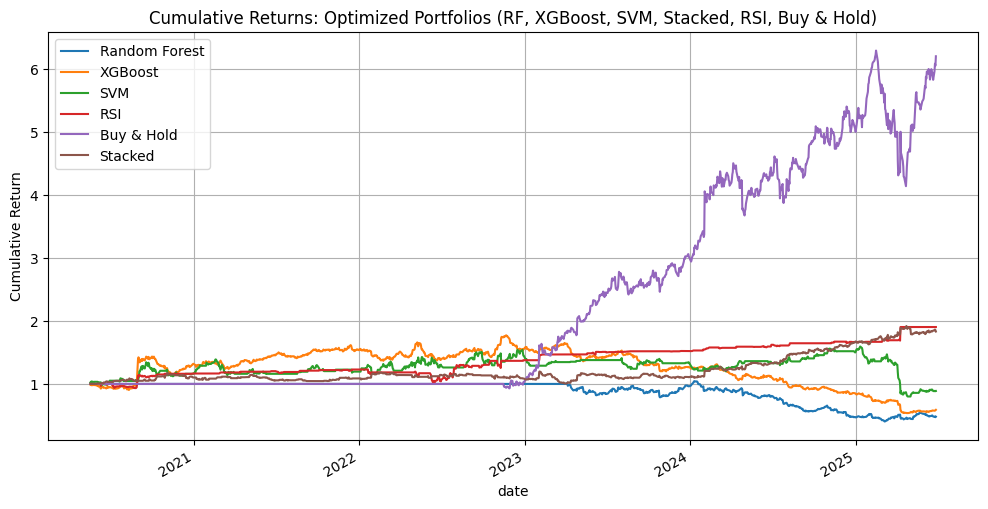

In [33]:
cumulative_returns_plot = {} # Renamed to avoid conflict with `cumulative_returns` dict above

# Iterate through optimized weights and calculate cumulative returns for plotting
for name, weights in optimized_weights.items():
    strat_dict = strategy_sets[name] # Get the corresponding strategy dictionary
    
    # Ensure strat_dict is not empty before concatenation
    if strat_dict:
        returns_df = pd.concat(strat_dict.values(), axis=1).fillna(0)
        portfolio_returns = returns_df.dot(weights)
        cumulative_returns_plot[name] = (1 + portfolio_returns).cumprod()
    else:
        print(f"Warning: No strategies found for '{name}'. Skipping plotting for this set.")

# Plot all optimized portfolios
if cumulative_returns_plot: # Check if there's anything to plot
    pd.DataFrame(cumulative_returns_plot).plot(figsize=(12,6), title="Cumulative Returns: Optimized Portfolios (RF, XGBoost, SVM, Stacked, RSI, Buy & Hold)")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
else:
    print("No cumulative returns to plot.")